# 決定木 Decision Tree による要因探索とメトリック記録

製造工程データに決定木を適用し、説明変数・因子がどのように製造品の良品・不良品に影響しているかを分析します。最初は普通のScikit Learnを使用し決定木で学習します。Azure Machine Learning service のメトリック記録機能を使って、作業内容を記録することも示します。

# 学習データの準備

In [1]:
import pandas as pd
import os 

df = pd.read_csv('./data/Factory.csv')

In [2]:
df.tail(10)

,ID,Quality,ProcessA-Pressure,ProcessA-Humidity,ProcessA-Vibration,ProcessB-Light,ProcessB-Skill,ProcessB-Temp,ProcessB-Rotation,ProcessC-Density,ProcessC-PH,ProcessC-skewness,ProcessC-Time
4888,4889,0,6.8,0.220,0.36,1.20,0.052,38.0,127.0,0.99330,3.04,0.54,9.2
4889,4890,0,4.9,0.235,0.27,11.75,0.030,34.0,118.0,0.99540,3.07,0.50,9.4
4890,4891,0,6.1,0.340,0.29,2.20,0.036,25.0,100.0,0.98938,3.06,0.44,11.8
4891,4892,0,5.7,0.210,0.32,0.90,0.038,38.0,121.0,0.99074,3.24,0.46,10.6
4892,4893,0,6.5,0.230,0.38,1.30,0.032,29.0,112.0,0.99298,3.29,0.54,9.7
4893,4894,0,6.2,0.210,0.29,1.60,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
4894,4895,0,6.6,0.320,0.36,8.00,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
4895,4896,0,6.5,0.240,0.19,1.20,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
4896,4897,1,5.5,0.290,0.30,1.10,0.022,20.0,110.0,0.98869,3.34,0.38,12.8
4897,4898,0,6.0,0.210,0.38,0.80,0.020,22.0,98.0,0.98941,3.26,0.32,11.8


In [3]:
X = df.drop(["Quality","ID"],axis=1)
y = df["Quality"].values

# 決定木 Decision Tree による学習

In [4]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X, y)

In [6]:
!pip install --upgrade pydotplus

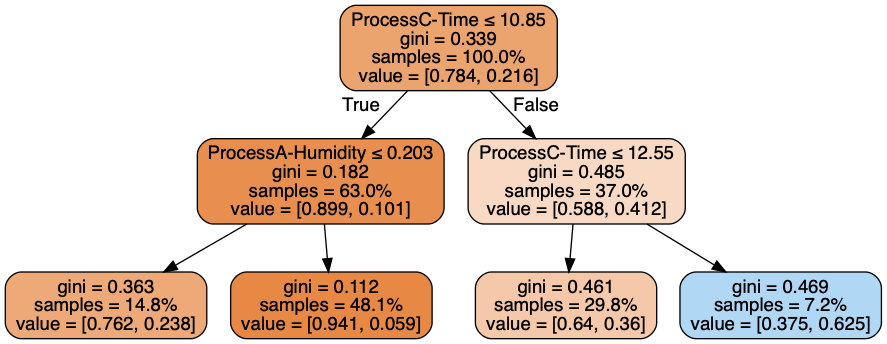

In [5]:
#import graphviz
import pydotplus as pdp
from IPython.display import Image

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, proportion=True, filled=True, rounded=True, special_characters=True)  
graph = pdp.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Azure Machine Learning service

# 事前準備

### Python SDK インポート

In [6]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
import logging
import pydotplus as pdp

/Users/konabuta/miniconda3/envs/amlservice/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [7]:
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.23


### Azure ML service ワークスペースとの接続

In [ ]:
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

### 実験 Expriment 設定

In [ ]:
experiment=Experiment(ws, "Logging_DecisionTree")

### メトリック記録の開始

In [ ]:
run = experiment.start_logging()

# 決定木 Decision Tree による学習

In [ ]:
max_depth = 2
criterion = 'gini'

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf = clf.fit(X, y)

# メトリック記録

### ハイパーパラメータの記録

In [ ]:
run.log("木の分割基準", criterion)
run.log("木の深さ", max_depth)

### 画像イメージの記録

In [ ]:
import graphviz
import pydotplus as pdp

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, proportion=True, filled=True, rounded=True, special_characters=True)  
graph = pdp.graph_from_dot_data(dot_data)
graph.write_png("tree.png")

In [ ]:
run.log_image(name = "DT image", path="tree.png")

### モデルファイルのアップロード

In [ ]:
import pickle
filename = 'DT-model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
run.upload_file(name= "outputs/"+filename, path_or_stream=filename)

### メトリック記録の完了

In [ ]:
run.complete()

In [ ]:
run

# モデル登録

In [ ]:
from azureml.core.model import Model

model = run.register_model(model_name='DT-sklearn', 
                           model_path = 'outputs/' + filename,
                           tags = {'area': "decision tree by sklearn", 'type': "classification", 'run_id' : run.id}
                          )

In [ ]:
print(model.name, model.version, model.tags)

# Webサービスとしてデプロイ

## モデル呼び出し

In [ ]:
model=Model(ws, 'DT-sklearn')

## 推論用コード

In [ ]:
%%writefile score_decisiontree.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('DT-sklearn')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict_proba(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

## パッケージ情報

In [ ]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

## Dockerイメージ設定

In [ ]:
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# 推論Dockerイメージの設定
image_config = ContainerImage.image_configuration(execution_script="score_decisiontree.py", runtime="python", conda_file="myenv.yml")

## Dockerイメージ作成

In [ ]:
%%time
from azureml.core.image import Image,ContainerImage
image = Image.create(name = "sklearn-decisiontree-image", models = [model],image_config = image_config, workspace = ws)
image.wait_for_creation(show_output = True)

In [ ]:
print(image.name, image.version, image.creation_state, image.image_location)

In [ ]:
%%time
from azureml.core.webservice import AciWebservice
import datetime

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, tags={'area': "decision tree", 'type': "classification"}, description='Decision Tree model from Quality Control')

service = Webservice.deploy_from_image(deployment_config=aciconfig,
                                        image=image,
                                        name="qc"+ datetime.datetime.now().strftime('%m%d%H%M'),
                                        workspace=ws)

service.wait_for_deployment(show_output=True)

## Webサービスのテスト

In [ ]:
import requests
import numpy as np
scoring_uri = service.scoring_uri

In [ ]:
# 入力データ
input_i = "5.5, 0.290, 0.30, 1.10, 0.022, 20.0, 110.0, 0.98869, 3.34, 0.38, 12.8"

In [ ]:
input_i = "5.5, 0.290, 0.30, 1.10, 0.022, 20.0, 110.0, 0.98869, 3.34, 0.38, 12.8"
input = np.array(input_i.split(","), dtype = np.float)

In [ ]:
import json
test_sample = json.dumps({'data': [input.tolist()]})
test_sample = bytes(test_sample,encoding = 'utf8')
print(test_sample)

In [ ]:
headers = { 'Content-Type':'application/json' }
resp = requests.post(scoring_uri, test_sample, headers = headers)
print(resp.text)